In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import os 
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image

In [12]:
path1 = "./images/archive/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "./images/archive/im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "./images/archive/im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "./images/archive/im_Parabasal/im_Parabasal/CROPPED/"
path5 = "./images/archive/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

height = 64 
weidth = 64
channel = 3
num_classes = 5
batch_size = 32
path = [path1,path2,path3,path4,path5]

**Data Input Pipeline**

In [13]:
i = 0 
data = []
label = []

for p in path :
    bmp_files = [f for f in os.listdir(p) if f.endswith('.bmp')]
    for file in bmp_files:
        label.append(i)
        image = cv2.imread(p+file)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_from_array = Image.fromarray(image_rgb,"RGB")
        size_image = image_from_array.resize((height,weidth))
        data.append(np.array(size_image))

    i +=1

C:\Users\Dell\AppData\Local\Temp\ipykernel_3296\1965971482.py:11: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_from_array = Image.fromarray(image_rgb,"RGB")


In [14]:
print(len(data))
print(len(label))
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def print_data(a):
    plt.imshow(data[a])
    plt.xlabel(categories[label[a]])

datas = torch.tensor(data)
label = torch.tensor(label)
normalized_data = datas/255

encoded_labels = torch.nn.functional.one_hot(label, num_classes=num_classes)
print(encoded_labels[3000])


4049
4049


C:\Users\Dell\AppData\Local\Temp\ipykernel_3296\4049571555.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  datas = torch.tensor(data)


tensor([0, 0, 0, 1, 0])


In [15]:
from torch.utils.data import DataLoader, TensorDataset, random_split

dataset = TensorDataset(normalized_data,encoded_labels)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) -train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 126 full batches of 32 samples and 1 additional batch of 17 sample

In [16]:
for batch in train_loader:
        images, labels = batch
        print(images.shape)

print(len(train_loader))

torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 

In [17]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

102
13
13


In [18]:
print("The shape of input data be: ", datas.shape)
print("The shape of label be : ", encoded_labels.shape)

The shape of input data be:  torch.Size([4049, 64, 64, 3])
The shape of label be :  torch.Size([4049, 5])


**Define Model**

In [3]:
import torch 
import torch.nn as nn 
import torchvision.models as models
import torch.nn.functional as F

efficientnet_b5 = models.efficientnet_b5(pretrained = True)

num_features = efficientnet_b5.classifier[1].in_features
efficientnet_b5.classifier[1] = nn.Linear(num_features, 5)

class EfficientNetWithSoftmax(nn.Module):
    def __init__(self, base_model):
        super(EfficientNetWithSoftmax, self).__init__()
        self.base_model = base_model

    def forward(self, x):
        logits = self.base_model(x) 
        return logits
    
model = EfficientNetWithSoftmax(efficientnet_b5)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




EfficientNetWithSoftmax(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
   

In [22]:
epochs = 10 
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0

    for batch in train_loader:
        images, labels = batch

        optimizer.zero_grad()
        #print(f"Original images shape: {images.shape}")
        images = images.permute(0, 3, 1, 2) 
        #print(f"Original images shape: {images.shape}")
        #outputs = model(images)
        #print(f"Outputs lenght: {len(outputs)}, Labels shape: {len(labels)}")
        #print(f"Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
        class_indices = torch.argmax(labels, dim=1)
        outputs = model(images)
        loss = criterion(outputs, class_indices)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss/len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images = images.permute(0, 3, 1, 2)
            class_indices = torch.argmax(labels, dim=1)
            outputs = model(images)
            loss = criterion(outputs, class_indices)

            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")



Epoch [1/10], Training Loss: 0.6319, Validation Loss: 1.3143
Epoch [2/10], Training Loss: 0.3225, Validation Loss: 0.7619
Epoch [3/10], Training Loss: 0.2136, Validation Loss: 0.3595
Epoch [4/10], Training Loss: 0.1243, Validation Loss: 0.3964
Epoch [5/10], Training Loss: 0.1279, Validation Loss: 0.1271
Epoch [6/10], Training Loss: 0.0992, Validation Loss: 0.2044
Epoch [7/10], Training Loss: 0.0999, Validation Loss: 0.6575
Epoch [8/10], Training Loss: 0.1035, Validation Loss: 0.2044
Epoch [9/10], Training Loss: 0.0996, Validation Loss: 0.2375
Epoch [10/10], Training Loss: 0.0408, Validation Loss: 0.1503


In [23]:
torch.save(model.state_dict(), 'model/model_V3.pth')

In [4]:
model.load_state_dict(torch.load('model/model_V3.pth'))

<All keys matched successfully>

In [25]:

images, labels = next(iter(train_loader))

# Permute images to match the input format (Batch, Channels, Height, Width)
images = images.permute(0, 3, 1, 2)


with torch.no_grad():
    outputs = model(images) 

_, predicted_classes = torch.max(outputs, 1)

# Convert labels to class indices if necessary
true_classes = torch.argmax(labels, dim=1)

predicted_classes = predicted_classes.numpy()
true_classes = true_classes.numpy()

print("Predicted classes: ", predicted_classes)
print("True classes: ", true_classes)

predicted_labels = [categories[i] for i in predicted_classes]
true_labels = [categories[i] for i in true_classes]

print("Predicted labels: ", predicted_labels)
print("True labels: ", true_labels)


Predicted classes:  [3 0 1 0 0 2 2 1 2 0 2 3 1 1 2 1 0 0 1 1 4 3 0 2 3 2 2 1 0 1 3 3]
True classes:  [3 0 1 0 0 2 2 1 2 0 2 3 1 1 2 1 0 0 1 1 4 3 0 2 3 2 2 1 0 1 3 3]
Predicted labels:  ['Parabasal', 'Dyskeratotic', 'Koilocytotic', 'Dyskeratotic', 'Dyskeratotic', 'Metaplastic', 'Metaplastic', 'Koilocytotic', 'Metaplastic', 'Dyskeratotic', 'Metaplastic', 'Parabasal', 'Koilocytotic', 'Koilocytotic', 'Metaplastic', 'Koilocytotic', 'Dyskeratotic', 'Dyskeratotic', 'Koilocytotic', 'Koilocytotic', 'Superficial-Intermediate', 'Parabasal', 'Dyskeratotic', 'Metaplastic', 'Parabasal', 'Metaplastic', 'Metaplastic', 'Koilocytotic', 'Dyskeratotic', 'Koilocytotic', 'Parabasal', 'Parabasal']
True labels:  ['Parabasal', 'Dyskeratotic', 'Koilocytotic', 'Dyskeratotic', 'Dyskeratotic', 'Metaplastic', 'Metaplastic', 'Koilocytotic', 'Metaplastic', 'Dyskeratotic', 'Metaplastic', 'Parabasal', 'Koilocytotic', 'Koilocytotic', 'Metaplastic', 'Koilocytotic', 'Dyskeratotic', 'Dyskeratotic', 'Koilocytotic', 'Koiloc

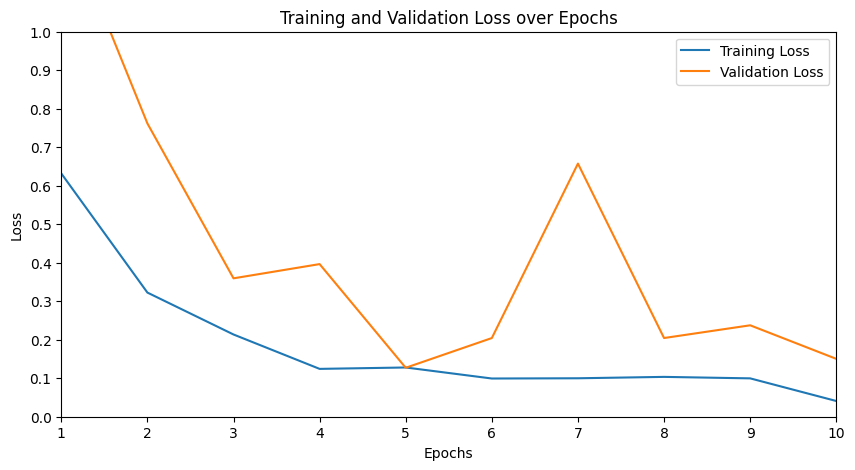

In [26]:

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')


x_ticks = np.arange(1, len(train_losses) + 1, 1)  
y_ticks = np.arange(0, 1.1, 0.1)  


plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.ylim(0, 1)  # Adjust y-axis to range from 0 to 1 (assuming loss range)
plt.xlim(1, len(train_losses))  # Adjust x-axis to range from 1 to the number of epochs


plt.legend()
plt.show()


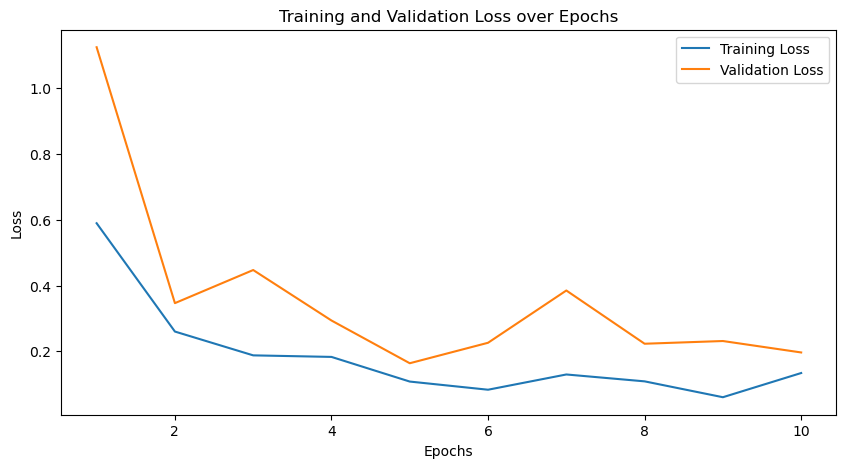

In [15]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')


plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

all_preds = []
all_labels = []

# Iterate over the test data
with torch.no_grad():
    for images, labels in test_loader:
        
        images = images.permute(0, 3, 1, 2)  

        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  
        
    
        true_classes = torch.argmax(labels, dim=1)

     
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(true_classes.cpu().numpy())


precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)


print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Accuracy: 0.9507
Precision: 0.9510
Recall: 0.9507
F1-score: 0.9507


For single image


In [ ]:
image = cv2.imread("./Sample_dataset/im_Superficial-Intermediate/001_03.bmp")


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)
image_resized = image_pil.resize((64, 64))
image_array = np.array(image_resized) / 255.0
image_tensor = torch.tensor(image_array, dtype=torch.float32)


image_tensor = image_tensor.permute(2, 0, 1).unsqueeze(0) 

model.eval()  
with torch.no_grad():
    output = model(image_tensor)  

_, predicted_class = torch.max(output, 1)  
predicted_class = predicted_class.item()


print("Predicted class:", predicted_class)
print("True class:", predicted_class)

predicted_label = categories[predicted_class]
true_label = categories[predicted_class]

print("Predicted label:", predicted_label)
print("True label:", true_label)


Predicted class: 4
True class: 4
Predicted label: Superficial-Intermediate
True label: Superficial-Intermediate
